# Use Matrix algebra for segmentNet

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Functions we are trying to approximate

In [3]:
np.random.seed(10)

# y = ax^4 + bx^3 + cx^2 + dx + f
def f_quarticn(x):
    a = -0.0179516
    b = 0.331323
    c = -1.53398
    d = -0.21107
    f = 5.73434
    x = x + 1
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f
    
def f_inv_quartic(x):
    return 7 - f_quartic(x)
    
def f_semicircle(x):
    maxX = x.max()
    minX = x.min()
    radius = (maxX - minX)/2 
    center = (maxX + minX)/2 
    y = np.sqrt(np.abs(radius**2 - (x-center)**2))
    return y
    
def frand(y):
    return y + y*np.random.uniform(-0.1, 0.1, y.shape).astype('f')

def normalize(x,y):
    mu_x = torch.mean(x)
    std_x = torch.std(x)

    mu_y = torch.mean(y)
    std_y = torch.std(y)

    x_normalized = torch.nn.functional.normalize(x - mu_x, dim=0)
    y_normalized = torch.nn.functional.normalize(y - mu_y, dim=0)
    return x_normalized, y_normalized

# Model definition

In [4]:
#Original V2 code

class OneLayerSegmentNet(nn.Module):
    def __init__(self, in_features, segment_features, alpha=0.0):
        super(OneLayerSegmentNet, self).__init__()
        self.segment_features = segment_features
        self.in_features = in_features
        self.weight = nn.Parameter(torch.Tensor(segment_features, in_features))
        nn.init.normal_(self.weight, -10, 10)
        self.bias = nn.Parameter(torch.Tensor(segment_features))
        self.alpha = alpha

    def forward(self, x,debug=False):
        y = torch.zeros(x.shape[0],1)
        #intersections store the X coordinates for intersection of consecutive segments (lines from weights)
        intersections = torch.Tensor(self.segment_features-1)

        #TODO: replace for loop with matrix if possible and necessary for performance
        for i in range(self.segment_features):
            yn = torch.matmul(x, self.weight[i]) + self.bias[i]
            yn = yn.unsqueeze(-1)
            print(("i=",i," linear:",yn.shape,"\n", yn.T) if debug else "")
            if(i < self.segment_features -1): # clamp only N-1 segments in the end
                # if next line is parallel to previous line (no intersection) then ignore this
                if self.weight[i] == self.weight[i+1]:
                    continue
                    
                intersections[i] = (self.bias[i+1] - self.bias[i])/(self.weight[i] - self.weight[i+1])

                # use alpha to avoid vanishing gradient
                mask = torch.ones_like(x).masked_fill((x >= intersections[i]), self.alpha)
                
                print(("upper_mask:",mask.T) if debug else "")
                #print(yn.shape, mask.shape)
                yn =  yn*mask
                print((i,":yn*upper_mask\n",yn.T) if debug else "")
                
            if(i >= 1): # Clamp X the beginning only second segment onwards
                # Create mask for X
                mask = torch.ones_like(x).masked_fill((x < intersections[i-1]), self.alpha)
                print(("lower_mask:",mask.T) if debug else "")
                yn =  yn*mask
                print((i,"yn:lower_mask\n",yn.T) if debug else "")
            y += yn
            print((i,":Yincr\n",y.T) if debug else "")
        print(("intersections\n",intersections) if debug else "")
        return y
            
    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, segment_features={self.segment_features}'

In [5]:
import torch
# Results match for loop implementation and on Macbook pro M1 this is 2x faster.

class OneLayerSegmentNetv3(torch.nn.Module):
    def __init__(self, in_features, segment_features, alpha=0.0):
        super(OneLayerSegmentNetv3, self).__init__()
        self.segment_features = segment_features
        self.in_features = in_features
        self.weight = nn.Parameter(torch.Tensor(segment_features, in_features))
        nn.init.normal_(self.weight, -10, 10)
        self.bias = nn.Parameter(torch.Tensor(segment_features))
        self.alpha = alpha
        self.intersections = torch.zeros(segment_features)

    def forward(self, x):
        # Stack features - we get yall[:,i] = yn(i) from for loop
        yall = x*self.weight.T + self.bias 
        
        #intersections are the X value of points of intersection of two lines
        # (this gives us starting and ending X values of a segment ie. projection on segment on x axis)
        intersections = (self.bias[1:] - self.bias[:-1])/((self.weight[:-1] - self.weight[1:]).squeeze(-1))
        
        #intersections are one less in shape than x. this ones matrix is added to mask later
        ones = torch.ones_like(x)
        
        # Create masks
        upper_mask = torch.ones((x.shape[0],intersections.shape[0])).masked_fill((x >= intersections), self.alpha)
        # append extra layer of ones on upper_mask so it matches segment size
        upper_mask = torch.cat((upper_mask, ones), dim=1)

        lower_mask = torch.ones((x.shape[0],intersections.shape[0])).masked_fill((x < intersections), self.alpha)
        # prepend extra layer of ones on lower_mask so it matches segment size
        lower_mask = torch.cat((ones, lower_mask), dim=1)
        
        # Apply masks
        yall = yall * upper_mask * lower_mask

        # Sum features
        y = yall.sum(dim=1).unsqueeze(-1)  # (N)

        return y


# Data Loaders

In [6]:
from torch.utils.data.dataloader import DataLoader

class InfiniteRandomDataLoader:

    def __init__(self, dataset, loss, replacement=True, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


## Model helper functions

In [7]:
def get_model_param_grad(model):
    dt = {}
    for param in model.parameters():
        if(param.shape == (model.segment_features,1)):
            dt['weight_grad'] = param.grad
        else:
            dt['bias_grad'] = param.grad
    return dt

# Model Training with random data loader

In [14]:
torch.manual_seed(10)

#model = OneLayerSegmentNet(1, 4, alpha=0.0)
model = OneLayerSegmentNetv3(1, 4, alpha=0.0)

# Init

In [15]:
# init training
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

# Capture params after initialization
model_params = []
model_param_grads = []
model_params.append(copy.deepcopy(model.state_dict()))

# init optimizer
criterion = nn.MSELoss(reduction='sum')

#create ys data from scratch so we can sort xs as needed - made no different with randomloader for segmentnet
f = f_quartic # select data function
xs = np.arange(-1.5, 11., .05)
ys = f(xs)
#print(xs.shape, ys.shape)

x = torch.tensor((xs).reshape(xs.shape[0],1), dtype=torch.float32)
ytest = torch.tensor((ys).reshape(ys.shape[0],1), dtype=torch.float32) # y is from function / not randomized

#Test normalization - works
x, ytest = normalize(x, ytest)

dataLoader = InfiniteRandomDataLoader

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x, ytest)

#initialize training params
step = 0
losses = np.array([])
with torch.no_grad():
    y = model(x)
    total_mean_loss = criterion(y, ytest)
#    losses = np.append(losses, total_mean_loss)

lr=.01
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=.5, patience=10000,threshold=0.01, threshold_mode='rel', cooldown=0, 
                                                 min_lr=0, eps=1e-08, verbose=True) # let us try scheduler to reduce learning rate

## Training loop

In [16]:
# training loop

torch.manual_seed(10)

best_loss = .01
prev_total_mean_loss = 100
max_steps = 20000

model.train() # We use this variable for training
# init dataloader
batch_loader = dataLoader(dataset,loss=total_mean_loss,replacement=False, batch_size=64, pin_memory=True, num_workers=1)

while True:
    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X, Y = batch_loader.next()
    #check for NaN
    if math.isnan(Y.mean()):
        print ("Breaking for NaN")
        break

    # Forward pass
    ypred = model(X)

    # Calculate the loss
    loss = criterion(ypred, Y)
    
    # Backward and optimize
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Evaluate model after this optimizer.step
    # we evaluate on complete data
    with torch.no_grad():
        y = model(x)
        total_mean_loss = criterion(y, ytest)
    losses = np.append(losses, total_mean_loss)

    optimizer.step() #Definitely needed
    step += 1
    scheduler.step(total_mean_loss)
    t1 = time.time()

    # store params (weights and biases) after each training step
    if step % 10 == 0:
        model_params.append(copy.deepcopy(model.state_dict()))
        model_param_grads.append(get_model_param_grad(model))
             
    # logging
    if step % 1000 == 0:         
        print(f"step {step} | loss {loss:.4f} | total_mean_loss {total_mean_loss:.4f} | step time {(t1-t0)*1000:.2f}ms")

    # termination conditions
    if max_steps >= 0 and step % max_steps == 0:
        break
        
    #if total_mean_loss.mean() < best_loss:
        break

    #if total_mean_loss.mean() > prev_total_mean_loss*1.5:
    #    break #we may want to change learning rate

    prev_total_mean_loss = total_mean_loss

step 1000 | loss 4.0953 | total_mean_loss 17.2407 | step time 0.82ms
step 2000 | loss 0.7883 | total_mean_loss 3.2968 | step time 0.47ms
step 3000 | loss 0.4537 | total_mean_loss 1.4871 | step time 0.47ms
step 4000 | loss 0.2719 | total_mean_loss 0.6999 | step time 0.46ms
step 5000 | loss 0.0851 | total_mean_loss 0.4023 | step time 0.50ms
step 6000 | loss 0.0763 | total_mean_loss 0.3361 | step time 0.48ms
step 7000 | loss 0.0412 | total_mean_loss 0.2495 | step time 0.48ms
step 8000 | loss 0.0261 | total_mean_loss 0.1261 | step time 0.48ms
step 9000 | loss 0.0224 | total_mean_loss 0.0816 | step time 0.49ms
step 10000 | loss 0.0193 | total_mean_loss 0.0590 | step time 0.49ms
step 11000 | loss 0.0116 | total_mean_loss 0.0472 | step time 0.47ms
step 12000 | loss 0.0106 | total_mean_loss 0.0403 | step time 0.46ms
step 13000 | loss 0.0083 | total_mean_loss 0.0374 | step time 0.52ms
step 14000 | loss 0.0091 | total_mean_loss 0.0343 | step time 0.58ms
step 15000 | loss 0.0071 | total_mean_loss

 prev_total_mean_loss  tensor(0.0323)


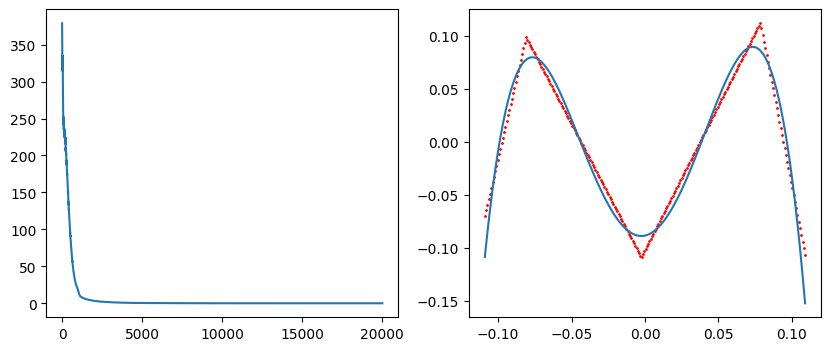

In [17]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print (" prev_total_mean_loss ",prev_total_mean_loss)
ax1.plot(losses)

# plot trained model
y = model(x)
yout = y.data.reshape(xs.shape[0])
ax2.plot(x, ytest)
ax2.scatter(x, yout, color='red', s=1)

# Display the plot
plt.show()

In [12]:
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
#graph.render("model_segment_v3_graph")

In [13]:
dict(model.named_modules())

{'': OneLayerSegmentNetv3()}